In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) #converted images into numpy

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


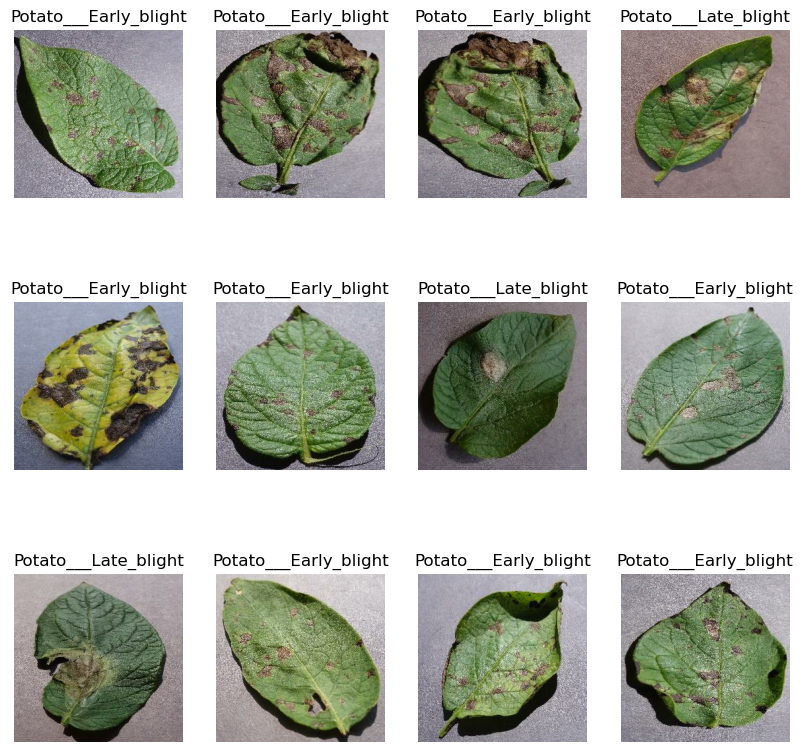

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1): #for images in each label
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
#80% for training
#10% for validation of data, other 10% for testing

In [9]:
train_size = 0.8
len(dataset)*train_size #calculating no of batches to take for training

54.400000000000006

In [10]:
train_ds = dataset.take(54) #getting first 54 batches for training
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54) #skipping first 54 batches and getting next 14 batches for training + validation
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size #calculating no of batches to take for validation

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6) #remaining batches are for testing
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=7)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #.cache() keeps image in memory
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #.prefetch() will load next set of batch from the disk (while gpu is training batch, cpu loads another batch)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #tensorflow determining how many batches to load while gpu is training

In [21]:
resize_and_rescale = tf.keras.Sequential([  #preprocessing images
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), #resizing images
    layers.experimental.preprocessing.Rescaling(1.0/255) #rescaling each image
]) #supply this layer when model is made

In [22]:
data_augmentation = tf.keras.Sequential([ #data augmentation by flipping and rotating images in a random manner
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
]) #this is done to prevent overfitting

In [23]:
ip = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale, data_augmentation, 
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = ip), #convolutional layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), #relu applies the rectified linear unit activation function - fastest method
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'), #Dense layer is a simple Layer of neurons in which each neuron receives input from all the neurons of the previous layer, thus called as dense. The dense layer is used to classify images based on output from convolutional layers.
    layers.Dense(n_classes, activation = 'softmax') #softmax normalises probablity of classes
])
model.build(input_shape = ip)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
optimizer = 'adam', #famous optimization algorithm
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), #Computes the crossentropy loss between the labels and predictions.
    metrics = ['accuracy'] #used to track the training process
)

In [26]:
history = model.fit(train_ds, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_data = val_ds)
#epoch is the number of passes a training dataset takes around an algorithm. 
#verbose tells us how we want to 'see' the training process

#training process

Epoch 1/50
54/54 [==============================] - 76s 1s/step - loss: 0.9237 - accuracy: 0.4883 - val_loss: 0.8212 - val_accuracy: 0.7396
Epoch 2/50
54/54 [==============================] - 71s 1s/step - loss: 0.7024 - accuracy: 0.7388 - val_loss: 0.5001 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 75s 1s/step - loss: 0.4426 - accuracy: 0.8369 - val_loss: 0.3791 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 77s 1s/step - loss: 0.3541 - accuracy: 0.8638 - val_loss: 0.2435 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 75s 1s/step - loss: 0.2473 - accuracy: 0.9079 - val_loss: 0.2133 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 75s 1s/step - loss: 0.1933 - accuracy: 0.9261 - val_loss: 0.1644 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 75s 1s/step - loss: 0.1631 - accuracy: 0.9349 - val_loss: 0.0982 - val_accuracy: 0.9740
Epoch 8/50
54/54 [==

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 265ms/step - loss: 0.0357 - accuracy: 0.9961


In [28]:
history

In [29]:
history.history['accuracy'] #python list which gives values of accuracy for each epoch iteration
#can be done for other values like loss, value loss and value accuracy

[0.48826292157173157,
 0.7388497591018677,
 0.8368544578552246,
 0.8638497591018677,
 0.9078638553619385,
 0.9260563254356384,
 0.9348591566085815,
 0.9436619877815247,
 0.9583333134651184,
 0.9260563254356384,
 0.9483568072319031,
 0.9642018675804138,
 0.9512910842895508,
 0.9718309640884399,
 0.9659624695777893,
 0.9718309640884399,
 0.9730046987533569,
 0.9683098793029785,
 0.9759389758110046,
 0.95363849401474,
 0.9735915660858154,
 0.9794601202011108,
 0.9542253613471985,
 0.9694835543632507,
 0.9818075299263,
 0.9788732528686523,
 0.9630281925201416,
 0.9589201807975769,
 0.9771126508712769,
 0.9800469279289246,
 0.9806337952613831,
 0.9741784334182739,
 0.9835680723190308,
 0.9800469279289246,
 0.9753521084785461,
 0.9818075299263,
 0.9812206625938416,
 0.9847418069839478,
 0.9782863855361938,
 0.9724178314208984,
 0.9812206625938416,
 0.987089216709137,
 0.9812206625938416,
 0.9911971688270569,
 0.9847418069839478,
 0.9953051805496216,
 0.9906103014945984,
 0.9923709034919739,


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

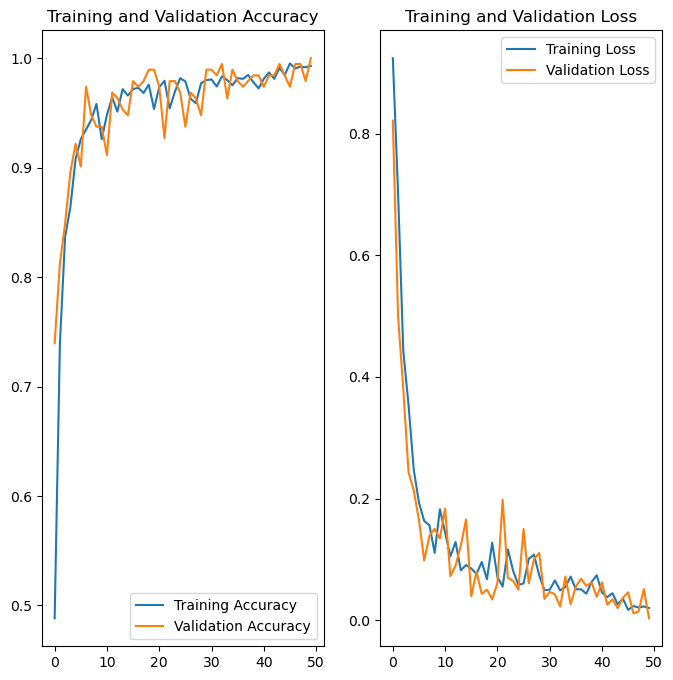

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 455ms/step
predicted label: Potato___Late_blight


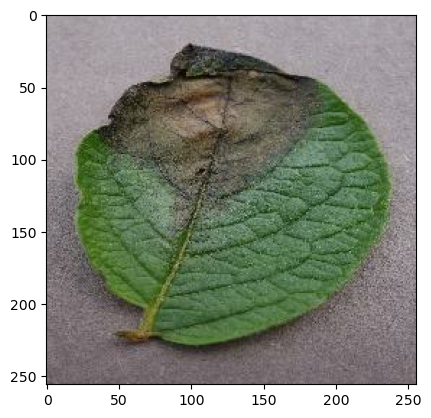

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1): #for images in each label
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch) #.predict function which predicts the label based on the image
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) #batch_prediction gives a 3d array as prediction answer, which is because we used 3 classes and softmax activation
    #the maximum of the 3d array gives the label name, and to find that we use np.argmax()

In [33]:
def predict(model, img): #function for prediction of disease of images
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())#convert image to image array
    img_array = tf.expand_dims(img_array, 0)#creating a batch out of image array

    predictions = model.predict(img_array)#store prediction

    predicted_class = class_names[np.argmax(predictions[0])]#finding predicted class
    confidence = round(100 * (np.max(predictions[0])), 2) #confidence score evaluated
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


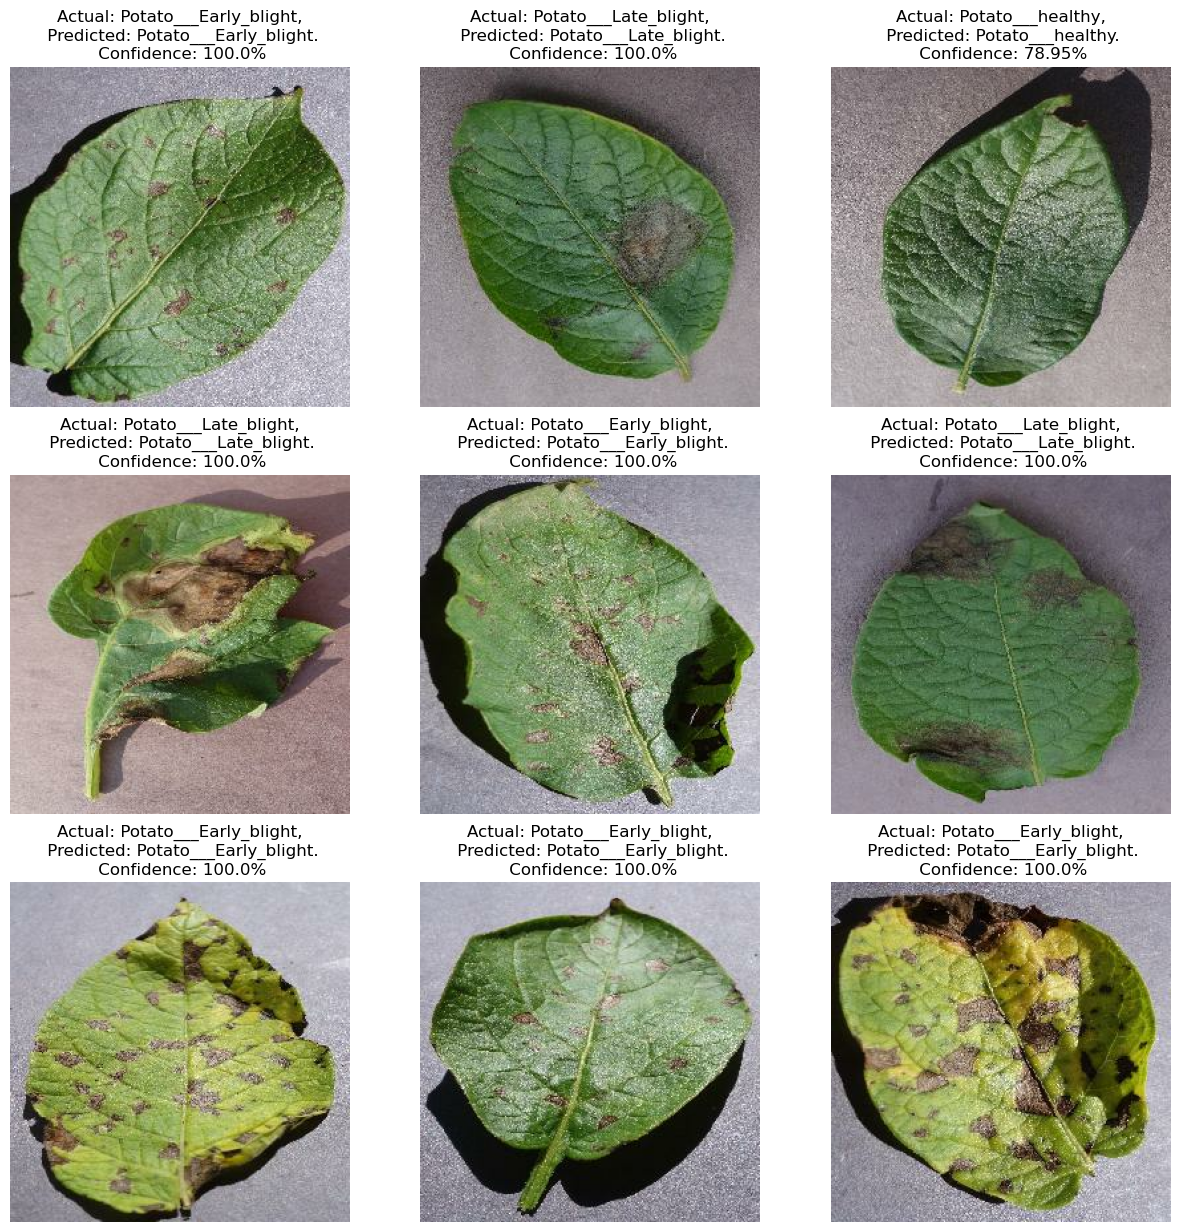

In [34]:
plt.figure(figsize=(15, 15)) #fixing image size (so it is visible)
for images, labels in test_ds.take(1):
    for i in range(9): #checking for 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())#calling predicted class & confidence from function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [36]:
#import os
#model_version=max([int(i) for i in os.listdir("../models") + [0]])+1 - code to save each model version as we need
#model.save(f"../models/{model_version}")